# Chapter 5

Examples and Exercises from Think Stats, 2nd Edition

http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT


In [1]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")

In [2]:
import numpy as np

import thinkstats2
import thinkplot

## Exponential distribution

Here's what the exponential CDF looks like with a range of parameters.

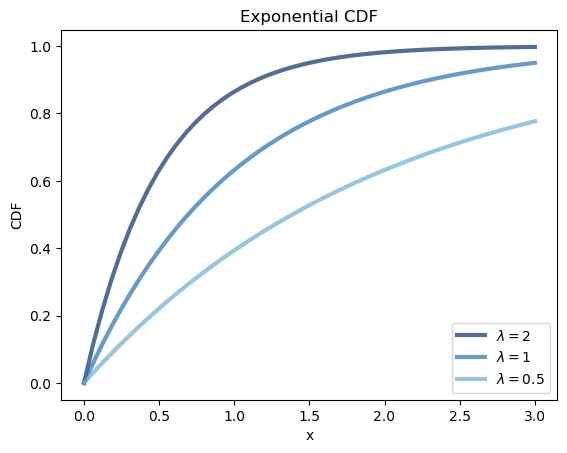

In [3]:
thinkplot.PrePlot(3)
for lam in [2.0, 1, 0.5]:
    xs, ps = thinkstats2.RenderExpoCdf(lam, 0, 3.0, 50)
    label = r"$\lambda=%g$" % lam
    thinkplot.Plot(xs, ps, label=label)

thinkplot.Config(title="Exponential CDF", xlabel="x", ylabel="CDF", loc="lower right")

Here's the distribution of interarrival times from a dataset of birth times.

In [4]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/analytic.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/babyboom.dat")

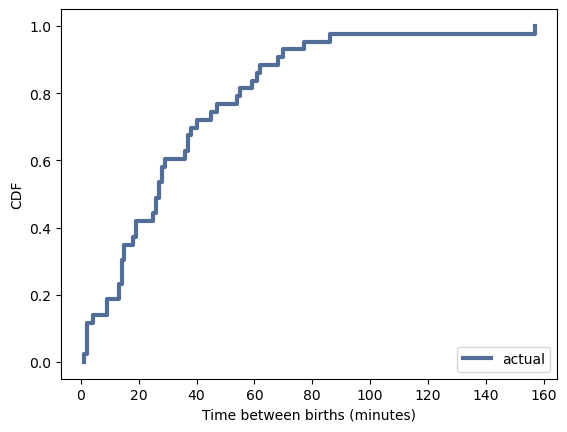

In [5]:
import analytic

df = analytic.ReadBabyBoom()
diffs = df.minutes.diff()
cdf = thinkstats2.Cdf(diffs, label="actual")

thinkplot.Cdf(cdf)
thinkplot.Config(xlabel="Time between births (minutes)", ylabel="CDF")

Here's what the CCDF looks like on a log-y scale.  A straight line is consistent with an exponential distribution.

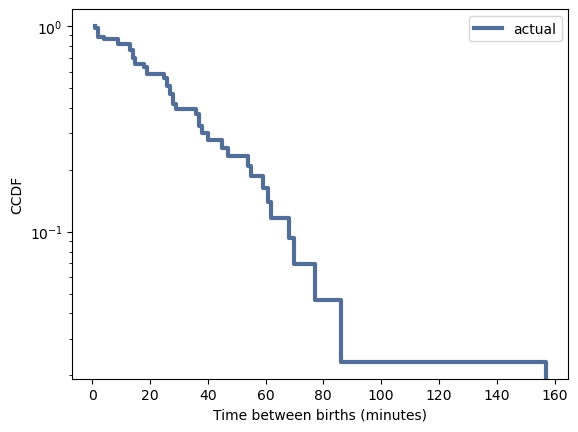

In [6]:
thinkplot.Cdf(cdf, complement=True)
thinkplot.Config(
    xlabel="Time between births (minutes)",
    ylabel="CCDF",
    yscale="log",
    loc="upper right",
)

## Normal distribution

Here's what the normal CDF looks like with a range of parameters.

In [8]:
thinkplot.PrePlot(3)

mus = [1.0, 2.0, 3.0]
sigmas = [0.5, 0.4, 0.3]
for mu, sigma in zip(mus, sigmas):
    xs, ps = thinkstats2.RenderNormalCdf(mu=mu, sigma=sigma, low=-1.0, high=4.0)
    label = r"$\mu=%g$, $\sigma=%g$" % (mu, sigma)
    thinkplot.Plot(xs, ps, label=label)

thinkplot.Config(title="Normal CDF", xlabel="x", ylabel="CDF", loc="upper left")

I'll use a normal model to fit the distribution of birth weights from the NSFG.

In [9]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/first.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dct")
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dat.gz"
)

In [10]:
import nsfg
import first

In [11]:
preg = nsfg.ReadFemPreg()
weights = preg.totalwgt_lb.dropna()

Here's the observed CDF and the model.  The model fits the data well except in the left tail.

In [12]:
# estimate parameters: trimming outliers yields a better fit
mu, var = thinkstats2.TrimmedMeanVar(weights, p=0.01)
print("Mean, Var", mu, var)

# plot the model
sigma = np.sqrt(var)
print("Sigma", sigma)
xs, ps = thinkstats2.RenderNormalCdf(mu, sigma, low=0, high=12.5)

thinkplot.Plot(xs, ps, label="model", color="0.6")

# plot the data
cdf = thinkstats2.Cdf(weights, label="data")

thinkplot.PrePlot(1)
thinkplot.Cdf(cdf)
thinkplot.Config(title="Birth weights", xlabel="Birth weight (pounds)", ylabel="CDF")

A normal probability plot is a visual test for normality.  The following example shows that if the data are actually from a normal distribution, the plot is approximately straight.

In [13]:
n = 1000
thinkplot.PrePlot(3)

mus = [0, 1, 5]
sigmas = [1, 1, 2]

for mu, sigma in zip(mus, sigmas):
    sample = np.random.normal(mu, sigma, n)
    xs, ys = thinkstats2.NormalProbability(sample)
    label = "$\mu=%d$, $\sigma=%d$" % (mu, sigma)
    thinkplot.Plot(xs, ys, label=label)

thinkplot.Config(
    title="Normal probability plot",
    xlabel="standard normal sample",
    ylabel="sample values",
)

Here's the normal probability plot for birth weights, showing that the lightest babies are lighter than we expect from the normal mode, and the heaviest babies are heavier.

In [14]:
mean, var = thinkstats2.TrimmedMeanVar(weights, p=0.01)
std = np.sqrt(var)

xs = [-4, 4]
fxs, fys = thinkstats2.FitLine(xs, mean, std)
thinkplot.Plot(fxs, fys, linewidth=4, color="0.8")

xs, ys = thinkstats2.NormalProbability(weights)
thinkplot.Plot(xs, ys, label="all live")

thinkplot.Config(
    title="Normal probability plot",
    xlabel="Standard deviations from mean",
    ylabel="Birth weight (lbs)",
)

If we suspect that the deviation in the left tail is due to preterm babies, we can check by selecting only full term births.

In [15]:
full_term = preg[preg.prglngth >= 37]
term_weights = full_term.totalwgt_lb.dropna()

Now the deviation in the left tail is almost gone, but the heaviest babies are still heavy.

In [16]:
mean, var = thinkstats2.TrimmedMeanVar(weights, p=0.01)
std = np.sqrt(var)

xs = [-4, 4]
fxs, fys = thinkstats2.FitLine(xs, mean, std)
thinkplot.Plot(fxs, fys, linewidth=4, color="0.8")

thinkplot.PrePlot(2)
xs, ys = thinkstats2.NormalProbability(weights)
thinkplot.Plot(xs, ys, label="all live")

xs, ys = thinkstats2.NormalProbability(term_weights)
thinkplot.Plot(xs, ys, label="full term")
thinkplot.Config(
    title="Normal probability plot",
    xlabel="Standard deviations from mean",
    ylabel="Birth weight (lbs)",
)

## Lognormal model

As an example of a lognormal disrtribution, we'll look at adult weights from the BRFSS.

In [17]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/brfss.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/CDBRFS08.ASC.gz")

In [18]:
import brfss

df = brfss.ReadBrfss()
weights = df.wtkg2.dropna()

The following function estimates the parameters of a normal distribution and plots the data and a normal model.

In [19]:
def MakeNormalModel(weights):
    """Plots a CDF with a Normal model.

    weights: sequence
    """
    cdf = thinkstats2.Cdf(weights, label="weights")

    mean, var = thinkstats2.TrimmedMeanVar(weights)
    std = np.sqrt(var)
    print("n, mean, std", len(weights), mean, std)

    xmin = mean - 4 * std
    xmax = mean + 4 * std

    xs, ps = thinkstats2.RenderNormalCdf(mean, std, xmin, xmax)
    thinkplot.Plot(xs, ps, label="model", linewidth=4, color="0.8")
    thinkplot.Cdf(cdf)

Here's the distribution of adult weights and a normal model, which is not a very good fit.

In [20]:
MakeNormalModel(weights)
thinkplot.Config(
    title="Adult weight, linear scale",
    xlabel="Weight (kg)",
    ylabel="CDF",
    loc="upper right",
)

Here's the distribution of adult weight and a lognormal model, plotted on a log-x scale.  The model is a better fit for the data, although the heaviest people are heavier than the model expects.

In [21]:
log_weights = np.log10(weights)
MakeNormalModel(log_weights)
thinkplot.Config(
    title="Adult weight, log scale",
    xlabel="Weight (log10 kg)",
    ylabel="CDF",
    loc="upper right",
)

The following function generates a normal probability plot.

In [22]:
def MakeNormalPlot(weights):
    """Generates a normal probability plot of birth weights.

    weights: sequence
    """
    mean, var = thinkstats2.TrimmedMeanVar(weights, p=0.01)
    std = np.sqrt(var)

    xs = [-5, 5]
    xs, ys = thinkstats2.FitLine(xs, mean, std)
    thinkplot.Plot(xs, ys, color="0.8", label="model")

    xs, ys = thinkstats2.NormalProbability(weights)
    thinkplot.Plot(xs, ys, label="weights")

When we generate a normal probability plot with adult weights, we can see clearly that the data deviate from the model systematically.

In [23]:
MakeNormalPlot(weights)
thinkplot.Config(
    title="Adult weight, normal plot",
    xlabel="Weight (kg)",
    ylabel="CDF",
    loc="upper left",
)

If we make a normal probability plot with log weights, the model fit the data well except in the tails, where the heaviest people exceed expectations.

In [24]:
MakeNormalPlot(log_weights)
thinkplot.Config(
    title="Adult weight, lognormal plot",
    xlabel="Weight (log10 kg)",
    ylabel="CDF",
    loc="upper left",
)

## Pareto distribution

Here's what the Pareto CDF looks like with a range of parameters.

In [25]:
xmin = 0.5

thinkplot.PrePlot(3)
for alpha in [2.0, 1.0, 0.5]:
    xs, ps = thinkstats2.RenderParetoCdf(xmin, alpha, 0, 10.0, n=100)
    thinkplot.Plot(xs, ps, label=r"$\alpha=%g$" % alpha)

thinkplot.Config(title="Pareto CDF", xlabel="x", ylabel="CDF", loc="lower right")

The distribution of populations for cities and towns is sometimes said to be Pareto-like.

In [ ]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/populations.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/PEP_2012_PEPANNRES_with_ann.csv")

In [26]:
import populations

pops = populations.ReadData()
print("Number of cities/towns", len(pops))

Here's the distribution of population for cities and towns in the U.S., along with a Pareto model.  The model fits the data well in the tail.

In [27]:
log_pops = np.log10(pops)
cdf = thinkstats2.Cdf(pops, label="data")
cdf_log = thinkstats2.Cdf(log_pops, label="data")

# pareto plot
xs, ys = thinkstats2.RenderParetoCdf(xmin=5000, alpha=1.4, low=0, high=1e7)
thinkplot.Plot(np.log10(xs), 1 - ys, label="model", color="0.8")

thinkplot.Cdf(cdf_log, complement=True)
thinkplot.Config(
    xlabel="log10 population", ylabel="CCDF", yscale="log", loc="lower left"
)

The lognormal model might be a better fit for this data (as is often the case for things that are supposed to be Pareto).

In [28]:
thinkplot.PrePlot(cols=2)

mu, sigma = log_pops.mean(), log_pops.std()
xs, ps = thinkstats2.RenderNormalCdf(mu, sigma, low=0, high=8)
thinkplot.Plot(xs, ps, label="model", color="0.8")

thinkplot.Cdf(cdf_log)
thinkplot.Config(xlabel="log10 population", ylabel="CDF", loc="lower right")

Here's a normal probability plot for the log-populations.  The model fits the data well except in the right tail, where the biggest cities are bigger than expected.

In [29]:
thinkstats2.NormalProbabilityPlot(log_pops, label="data")
thinkplot.Config(xlabel="Random variate", ylabel="log10 population", xlim=[-5, 5])

## Random variates

When we have an analytic CDF, we can sometimes invert it to generate random values.  The following function generates values from an exponential distribution.

In [30]:
import random


def expovariate(lam):
    p = random.random()
    x = -np.log(1 - p) / lam
    return x

We can test it by generating a sample.

In [31]:
t = [expovariate(lam=2) for _ in range(1000)]

And plotting the CCDF on a log-y scale.

In [32]:
cdf = thinkstats2.Cdf(t)

thinkplot.Cdf(cdf, complement=True)
thinkplot.Config(xlabel="Exponential variate", ylabel="CCDF", yscale="log")

A straight line is consistent with an exponential distribution.

## Exercises

**Exercise:** Write a function that generates a Pareto variate. Generate a sample and plot its complementary CDF on a log-log scale. Does it look like a straight line?

**Exercise:** In the BRFSS (see Section 5.4), the distribution of heights is roughly normal with parameters µ = 178 cm and σ = 7.7 cm for men, and µ = 163 cm and σ = 7.3 cm for women.

In order to join Blue Man Group, you have to be male between 5’10” and 6’1” (see http://bluemancasting.com). What percentage of the U.S. male population is in this range? Hint: use `scipy.stats.norm.cdf`.

`scipy.stats` contains objects that represent analytic distributions

In [35]:
import scipy.stats

For example <tt>scipy.stats.norm</tt> represents a normal distribution.

In [36]:
mu = 178
sigma = 7.7
dist = scipy.stats.norm(loc=mu, scale=sigma)
type(dist)

A "frozen random variable" can compute its mean and standard deviation.

In [37]:
dist.mean(), dist.std()

It can also evaluate its CDF.  How many people are below the mean by more than one standard deviation?  About 16%

In [38]:
dist.cdf(mu - sigma)

How many people are between 5'10" and 6'1"?

**Exercise:** To get a feel for the Pareto distribution, let’s see how different the world would be if the distribution of human height were Pareto. With the parameters xm = 1 m and α = 1.7, we get a distribution with a reasonable minimum, 1 m, and median, 1.5 m.

Plot this distribution. What is the mean human height in Pareto world? What fraction of the population is shorter than the mean? If there are 7 billion people in Pareto world, how many do we expect to be taller than 1 km? How tall do we expect the tallest person to be?

`scipy.stats.pareto` represents a pareto distribution.  In Pareto world, the distribution of human heights has parameters alpha=1.7 and xmin=1 meter.  So the shortest person is 100 cm and the median is 150.

In [40]:
alpha = 1.7
xmin = 1  # meter
dist = scipy.stats.pareto(b=alpha, scale=xmin)
dist.median()

What is the mean height in Pareto world?

What fraction of people are shorter than the mean?

Out of 7 billion people, how many do we expect to be taller than 1 km?  You could use <tt>dist.cdf</tt> or <tt>dist.sf</tt>.

How tall do we expect the tallest person to be?

**Exercise:** The Weibull distribution is a generalization of the exponential distribution that comes up in failure analysis (see http://wikipedia.org/wiki/Weibull_distribution). Its CDF is

$\mathrm{CDF}(x) = 1 − \exp[−(x / λ)^k]$ 

Can you find a transformation that makes a Weibull distribution look like a straight line? What do the slope and intercept of the line indicate?

Use `random.weibullvariate` to generate a sample from a Weibull distribution and use it to test your transformation.

Generate a sample from a Weibull distribution and plot it using a transform that makes a Weibull distribution look like a straight line.

If you are stuck, you can get a hint from `thinkplot.Cdf`, which provides a transform that makes the CDF of a Weibull distribution look like a straight line.  Here's an example that shows how it's used.

In [46]:
sample = [random.weibullvariate(2, 1) for _ in range(1000)]
cdf = thinkstats2.Cdf(sample)
thinkplot.Cdf(cdf, transform="weibull")
thinkplot.Config(xlabel="Weibull variate", ylabel="CCDF")

**Exercise:** For small values of `n`, we don’t expect an empirical distribution to fit an analytic distribution exactly. One way to evaluate the quality of fit is to generate a sample from an analytic distribution and see how well it matches the data.

For example, in Section 5.1 we plotted the distribution of time between births and saw that it is approximately exponential. But the distribution is based on only 44 data points. To see whether the data might have come from an exponential distribution, generate 44 values from an exponential distribution with the same mean as the data, about 33 minutes between births.

Plot the distribution of the random values and compare it to the actual distribution. You can use random.expovariate to generate the values.

In [47]:
import analytic

df = analytic.ReadBabyBoom()
diffs = df.minutes.diff()
cdf = thinkstats2.Cdf(diffs, label="actual")

n = len(diffs)
lam = 44.0 / 24 / 60
sample = [random.expovariate(lam) for _ in range(n)]

1 / lam, np.mean(sample)

**Bonus Example:** The distributions of wealth and income are sometimes modeled using lognormal and Pareto distributions. To see which is better, let’s look at some data.

The Current Population Survey (CPS) is a joint effort of the Bureau of Labor Statistics and the Census Bureau to study income and related variables. Data collected in 2013 is available from http://www.census.gov/hhes/www/cpstables/032013/hhinc/toc.htm. I downloaded `hinc06.xls`, which is an Excel spreadsheet with information about household income, and converted it to `hinc06.csv`, a CSV file you will find in the repository for this book. You will also find `hinc.py`, which reads this file.

Extract the distribution of incomes from this dataset. Are any of the analytic distributions in this chapter a good model of the data?

In [ ]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/hinc.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/hinc06.csv")

In [50]:
import hinc

df = hinc.ReadData()
df

Here's what the CDF looks like on a linear scale.

In [51]:
xs, ps = df.income.values, df.ps.values
cdf = thinkstats2.Cdf(xs, ps, label="data")
cdf_log = thinkstats2.Cdf(np.log10(xs), ps, label="data")

# linear plot
thinkplot.Cdf(cdf)
thinkplot.Config(xlabel="household income", ylabel="CDF")

To check whether a Pareto model describes the data well, I plot the CCDF on a log-log scale.

I found parameters for the Pareto model that match the tail of the distribution.

In [52]:
xs, ys = thinkstats2.RenderParetoCdf(xmin=55000, alpha=2.5, low=0, high=250000)

thinkplot.Plot(xs, 1 - ys, label="model", color="0.8")

thinkplot.Cdf(cdf, complement=True)
thinkplot.Config(
    xlabel="log10 household income",
    ylabel="CCDF",
    xscale="log",
    yscale="log",
    loc="lower left",
)

For the lognormal model I estimate mu and sigma using percentile-based statistics (median and IQR).

In [53]:
median = cdf_log.Percentile(50)
iqr = cdf_log.Percentile(75) - cdf_log.Percentile(25)
std = iqr / 1.349

# choose std to match the upper tail
std = 0.35
print(median, std)

Here's what the distribution, and fitted model, look like on a log-x scale.

In [54]:
xs, ps = thinkstats2.RenderNormalCdf(median, std, low=3.5, high=5.5)
thinkplot.Plot(xs, ps, label="model", color="0.8")

thinkplot.Cdf(cdf_log)
thinkplot.Config(xlabel="log10 household income", ylabel="CDF")

My conclusions based on these figures are:

1) The Pareto model might be a reasonable choice for the top
   10-20% of incomes.

2) The lognormal model captures the shape of the distribution better,
   with some deviation in the left tail.  With different
   choices for sigma, you could match the upper or lower tail, but not
   both at the same time.
 
In summary I would say that neither model captures the whole distribution,
so you might have to 

1) look for another analytic model, 

2) choose one that captures the part of the distribution that is most 
   relevent, or 

3) avoid using an analytic model altogether.